### Politeness prediction with ConvoKit

This notebook demonstrates functionalities of politeness strategies, as well as how to train a simple classifier to predict the politeness level of a request by considering the politeness strategies used, as seen in the paper [A computational approach to politeness with application to social factors](https://www.cs.cornell.edu/~cristian/Politeness.html), using ConvoKit. 

Note that this notebook is *not* intended to reproduce the paper results: legacy code for reproducibility is available at this [repository](https://github.com/sudhof/politeness). 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

In [2]:
import convokit

In [3]:
from convokit import Corpus, Speaker, Utterance
from convokit import download

In [4]:
from pandas import DataFrame
from typing import List, Dict, Set

#### 1. Getting data 
Stanford politeness corpus can be directly downloaded, we will be using the wikipedia portion. 

In [5]:
# Downloading the wikipedia portion of annotated data
wiki_corpus = Corpus(download("wikipedia-politeness-corpus"))

#### 2: Annotate the corpus with politeness strategies

To get politeness strategies for each utterance, we will first obtain dependency parses for the utterances, and then check for strategy use. 

- adding dependency parses

In [6]:
from convokit import TextParser


In [7]:
parser = TextParser(verbosity=1000)

In [8]:
wiki_corpus = parser.transform(wiki_corpus)

1000/4353 utterances processed
2000/4353 utterances processed
3000/4353 utterances processed
4000/4353 utterances processed
4353/4353 utterances processed


- adding strategy information

In [9]:
from convokit import PolitenessStrategies
ps = PolitenessStrategies()

In [10]:
wiki_corpus = ps.transform(wiki_corpus, markers=True)

Below is an example of all the meta information a processed utterance now has:
* `parsed` stores dependency parses
* `politeness_strategies` stores politeness strategy usage 
* `politeness_markers` keeps positive occurances of each politeness strategies.

In [11]:
wiki_corpus.get_utterance('434044').meta

{'Normalized Score': 0.6945444785369653,
 'Binary': 1,
 'Annotations': {'A233ONYNWKDIYF': 17,
  'A1QV3X9YMQQ3OQ': 22,
  'A3OW54MEVDKXJL': 17,
  'A1JK9DYKWYZZEK': 17,
  'AZ1RJVNOZFIWV': 18},
 'parsed': [{'rt': 7,
   'toks': [{'tok': 'hey', 'tag': 'UH', 'dep': 'intj', 'up': 1, 'dn': []},
    {'tok': 'mbk', 'tag': 'NNP', 'dep': 'dep', 'up': 7, 'dn': [0]},
    {'tok': ';', 'tag': ':', 'dep': 'punct', 'up': 7, 'dn': []},
    {'tok': 'well', 'tag': 'UH', 'dep': 'intj', 'up': 7, 'dn': []},
    {'tok': ',', 'tag': ',', 'dep': 'punct', 'up': 7, 'dn': []},
    {'tok': 'i', 'tag': 'PRP', 'dep': 'nsubj', 'up': 7, 'dn': []},
    {'tok': 've', 'tag': 'VB', 'dep': 'aux', 'up': 7, 'dn': []},
    {'tok': 'got', 'tag': 'VBN', 'dep': 'ROOT', 'dn': [1, 2, 3, 4, 5, 6, 9]},
    {'tok': 'to', 'tag': 'TO', 'dep': 'aux', 'up': 9, 'dn': []},
    {'tok': 'be', 'tag': 'VB', 'dep': 'xcomp', 'up': 7, 'dn': [8, 10]},
    {'tok': 'honest', 'tag': 'JJ', 'dep': 'acomp', 'up': 9, 'dn': []}]},
  {'rt': 12,
   'toks': [{'

Here is a clearer view of the politeness_markers:

In [12]:
utt = wiki_corpus.get_utterance('434044')
print("RAW TEXT: " + utt.text + "\n")
for ((k,v),(k1,v2)) in zip(utt.meta["politeness_strategies"].items(),utt.meta["politeness_markers"].items()):
    if v != 0:
        print(k[21:len(k)-2] + " results:")
        print("Markers: " + str(v2) + "\n")

RAW TEXT: Hey MBK; well, I've got to be honest I wasn't expecting the events of last night - personally I thought the discussion was going reasonably well (not fabulously, but we were getting somewhere) and, whilst I agree that Mlm's actions weren't exactly advised, I must admit it does seem to be a relatively minor thing to retire over - was there something else going on here that made it the straw that broke his back? Anyhow, I agree with you that he'll be greatly missed - I sent him a message on NSF but I doubt if I'll get any reply - what are your thoughts on the matter?

HASHEDGE results:
Markers: [[('thought', 1, 12)], [('relatively', 3, 10)], [('doubt', 5, 2)]]

Hedges results:
Markers: [[('i', 1, 11), ('thought', 1, 12)], [('i', 5, 1), ('doubt', 5, 2)]]

1st_person_pl. results:
Markers: [[('we', 1, 24)]]

1st_person results:
Markers: [[('i', 0, 5)], [('i', 1, 11)], [('i', 2, 3)], [('i', 3, 1)], [('i', 4, 2)], [('i', 4, 13)], [('i', 5, 1)], [('i', 5, 4)]]

1st_person_start resul

You may want to save the corpus by doing `wiki_corpus.dump("wiki-politeness-annotated")` for further exploration. Note that if you do not specify a base path, data will be saved to `.convokit/saved-corpora` in your home directory by default. 

To get a glimpse of the overall use of politeness strategies in this corpus: 

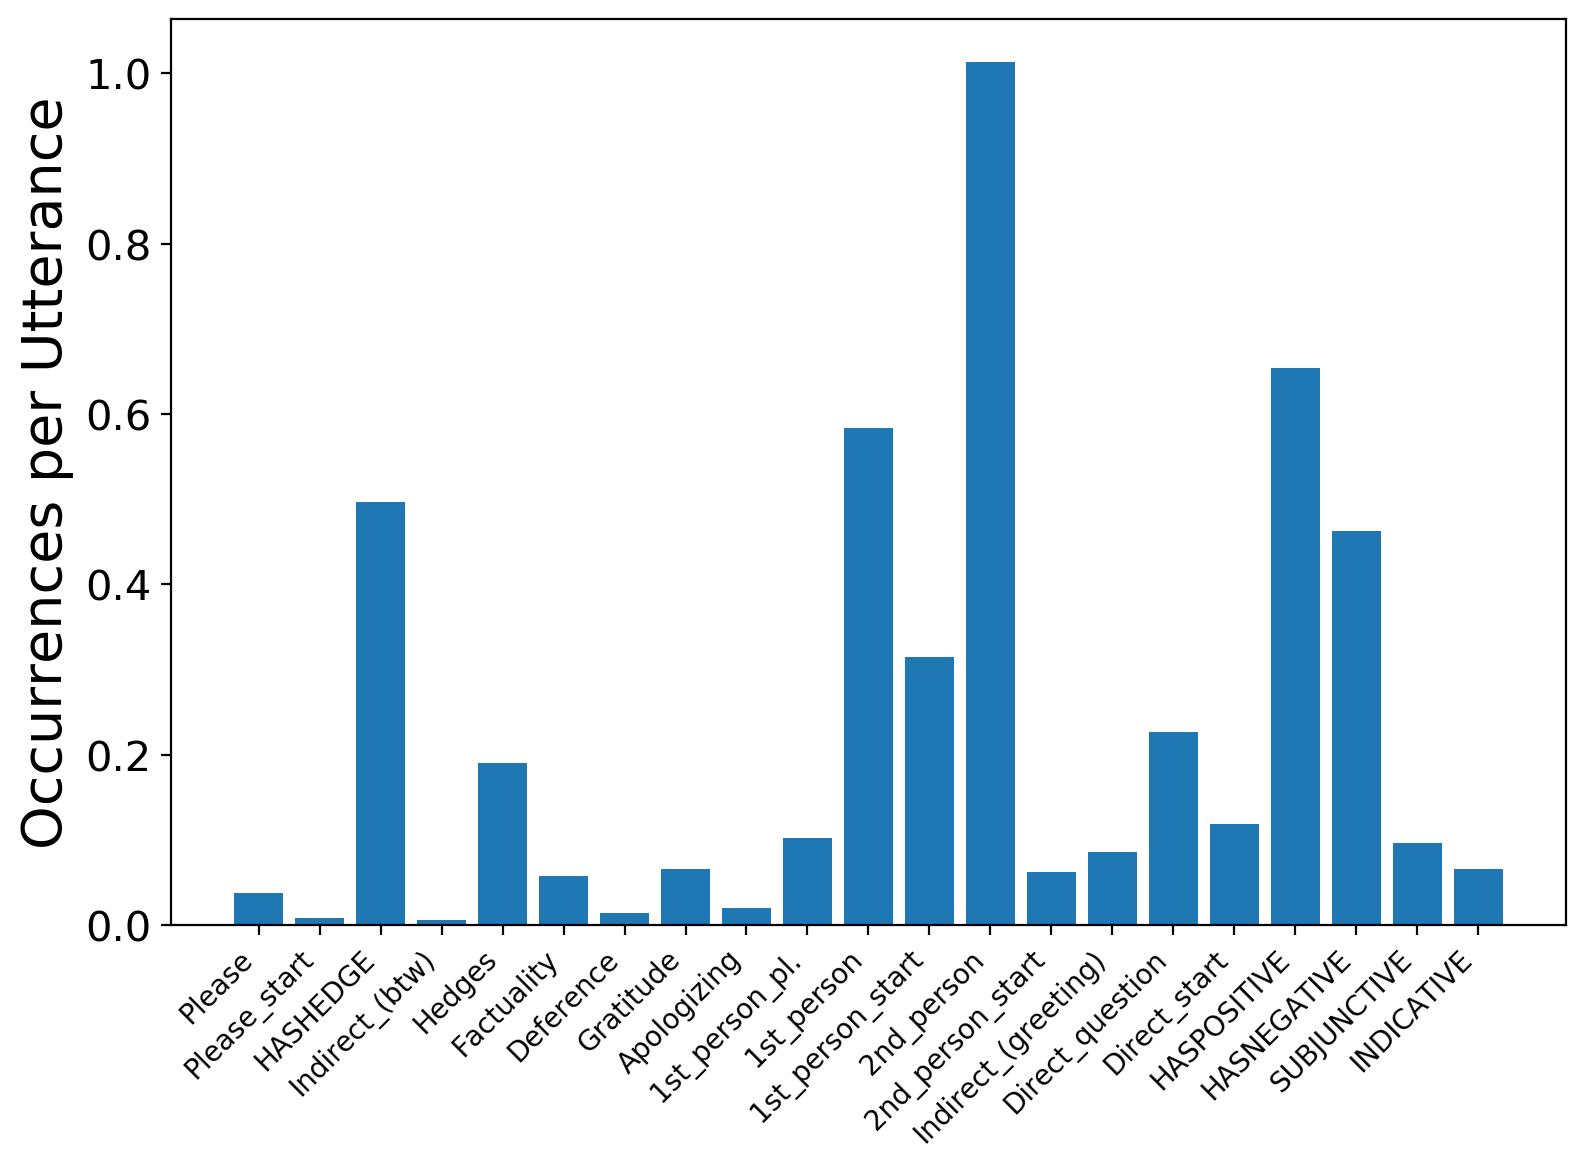

In [13]:
data = ps.summarize(wiki_corpus, plot=True)

You can also look at particular sections of the dataset, such as only the utterances that use positive words:

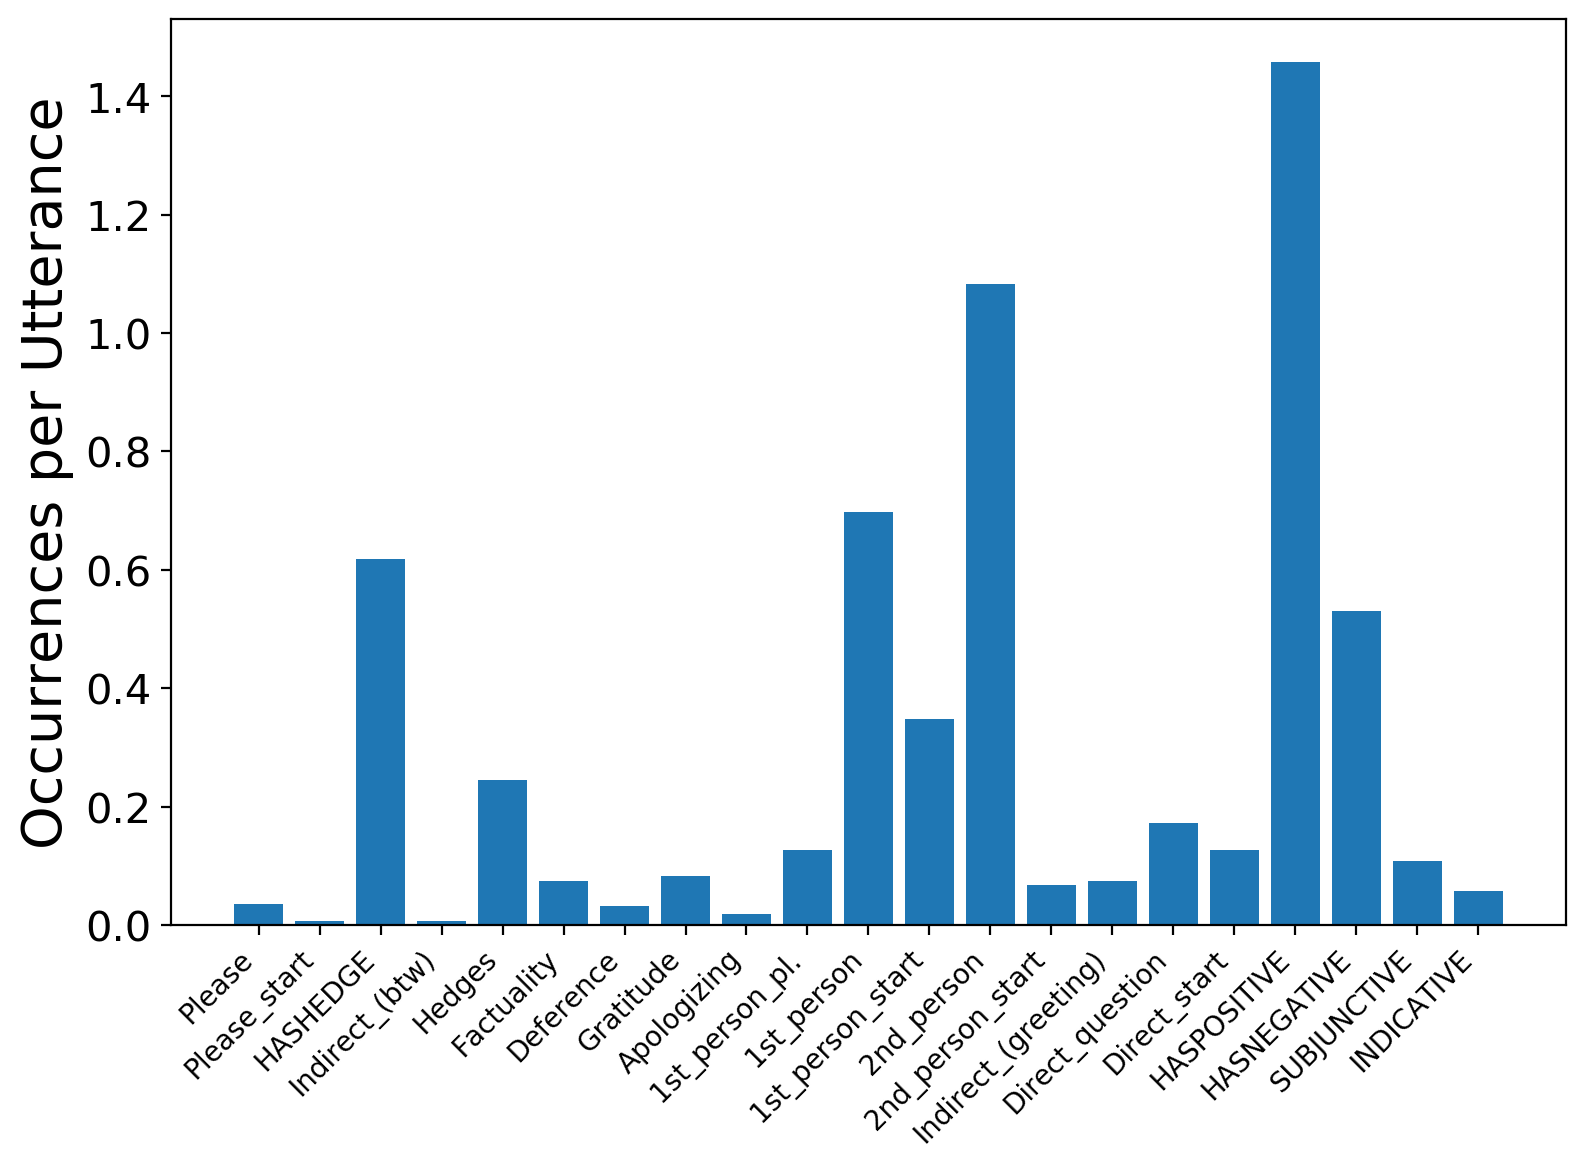

In [14]:
query = lambda x : x.meta["politeness_strategies"]["feature_politeness_==HASPOSITIVE=="] == 1
positive_data = ps.summarize(wiki_corpus, query, plot = True)

#### 3. Predict Politeness 

We will see how a simple classifier considering the use of politeness strategies perform, using `Classifier` (note that this is only for demonstration, and not geared towards achieving best performance).

In [15]:
import random
from sklearn import svm
from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report

In [16]:
from convokit import Classifier

As a prestep, we subset the corpus as we will only consider the polite vs. impolite class for prediction (i.e., those with "Binary" field being either +1 or -1). 

In [17]:
binary_corpus = Corpus(utterances=[utt for utt in wiki_corpus.iter_utterances() if utt.meta["Binary"] != 0])

#### 3.1 Direct evaluation

If you are interested in how effectiveness are these politeness strategies, `Classifier` provides evaluation with both train/test splits, as well as with cross validaton. 

- cross validation accuracies

In [18]:
clf_cv = Classifier(obj_type="utterance", 
                        pred_feats=["politeness_strategies"], 
                        labeller=lambda utt: utt.meta['Binary'] == 1)

clf_cv.evaluate_with_cv(binary_corpus)

Using corpus objects...
Running a cross-validated evaluation...
Done.


array([0.73853211, 0.73165138, 0.74541284, 0.75862069, 0.74022989])

- train/test split

In [19]:
clf_split = Classifier(obj_type="utterance", 
                        pred_feats=["politeness_strategies"], 
                        labeller=lambda utt: utt.meta['Binary'] == 1)

clf_split.evaluate_with_train_test_split(binary_corpus)

Using corpus objects...
Running a train-test-split evaluation...
Done.


(0.7477064220183486,
 array([[174,  51],
        [ 59, 152]]))

#### 3.2 Training a classifier to predict on other utterances

In [20]:
test_ids = binary_corpus.get_utterance_ids()[-100:]
train_corpus = Corpus(utterances=[utt for utt in binary_corpus.iter_utterances() if utt.id not in test_ids])
test_corpus = Corpus(utterances=[utt for utt in binary_corpus.iter_utterances() if utt.id in test_ids])
print("train size = {}, test size = {}".format(len(train_corpus.get_utterance_ids()),
                                               len(test_corpus.get_utterance_ids())))

train size = 2078, test size = 100


We can also train a classifier with a corpus to predict politeness labels for other Utterances. As an example, we will first train with a training corpus, and check predictions on some test utterances. 

In [21]:
clf = Classifier(obj_type="utterance", 
                        pred_feats=["politeness_strategies"], 
                        labeller=lambda utt: utt.meta['Binary'] == 1)
clf.fit(train_corpus)

- predicing on the test corpus (you can also predict on a list of utterances by using `clf.transform_objs()` instead) 

In [22]:
test_pred = clf.transform(test_corpus)

In [23]:
clf.summarize(test_pred)

,prediction,pred_score
id,,
626728,0,0.032777
622173,0,0.061533
452664,0,0.063063
623952,0,0.066285
621114,0,0.066330
...,...,...
439715,1,0.963585
464868,1,0.987237
29829,1,0.989377


To look at a few example predictions:

In [24]:
pred2label = {1: "polite", 0: "impolite"}

for i, idx in enumerate(test_ids[0:5]):
    print(i)
    test_utt = test_corpus.get_utterance(idx)
    ypred, yprob = test_utt.meta['prediction'], test_utt.meta['pred_score']
    print("test utterance:\n{}".format(test_utt.text))
    print("------------------------")
    print("Result: {}, probability estimates = {}\n".format(pred2label[ypred], yprob))

0
test utterance:
I understood just fine, but wasn't at my computer. Are you in a hurry?
------------------------
Result: polite, probability estimates = 0.8251819967567803

1
test utterance:
I've always been intrigued by 'dark-complected man.' What's with the radio, and fist in the air?
------------------------
Result: impolite, probability estimates = 0.09852978402835547

2
test utterance:
Your early edit's clearly indicate that you were not a newbie. How do explain this?
------------------------
Result: impolite, probability estimates = 0.29766900713379885

3
test utterance:
Instead of another 3O, why don't you put in a <url>. And no, it's not a threat - it's an observation - why don't you <url>?
------------------------
Result: impolite, probability estimates = 0.032776609012438174

4
test utterance:
Great Article RaveenS, Do u want me to add this to the template (Sri Lankan Conflict)? I think it should be included in the ''see also'' section what do you suggest?
------------------

We can also check out the confusion matrix and classification report 

In [25]:
clf.confusion_matrix(test_corpus)

array([[34, 12],
       [18, 36]])

In [27]:
print(clf.classification_report(test_corpus))

              precision    recall  f1-score   support

       False       0.65      0.74      0.69        46
        True       0.75      0.67      0.71        54

    accuracy                           0.70       100
   macro avg       0.70      0.70      0.70       100
weighted avg       0.71      0.70      0.70       100



We note that this is an implementation of a politeness classifier trained on a specific dataset (wikipedia) and on a specific binarization of politeness classes. Depending on your scenario, you might find it preferable to directly use the politeness strategies, as exemplified in the [conversations gone awry example](https://github.com/CornellNLP/ConvoKit/blob/master/examples/conversations-gone-awry/Conversations_Gone_Awry_Prediction.ipynb), rather than a politeness label/score.

In [28]:
df_model = pd.read_csv('/nethome/bhe46/program/counter_misinfo/counter_reply_prediction_task/bing_11_22_22/df_model.csv', dtype=str, lineterminator='\n')

In [35]:
df_model = df_model.head(1000)

In [36]:
df_model.head(5)['text']

0    with all the restrictions on resturants and ba...
1    im not gonna take vaccine till i see how it af...
2    50 million americans may die from covid 19 vac...
3                   they need to create a damn vaccine
4    trump s legacy is the plague of extreme lies t...
Name: text, dtype: object

In [37]:
text_sentences = df_model["text"].to_list()

In [38]:
utterances = [Utterance(speaker=Speaker(), id=str(i), text=x) for i, x in enumerate(text_sentences)]
my_corpus = Corpus(utterances=utterances)
len(list(my_corpus.utterances.values()))

1000

In [39]:
# parse the text first
parser = TextParser(verbosity=10000)
my_corpus = parser.transform(my_corpus)

# create the feature of my strategies:
ps = PolitenessStrategies(verbose=10000)
my_corpus = ps.transform(my_corpus, markers=True)

1000/1000 utterances processed


In [40]:
test_pred = clf.transform(my_corpus)

In [41]:
test_pred

In [52]:
clf.summarize(test_pred)

,prediction,pred_score
id,,
613,0,0.007831
654,0,0.033930
923,0,0.034380
78,0,0.034405
43,0,0.034405
...,...,...
552,1,0.871553
90,1,0.913256
270,1,0.926207


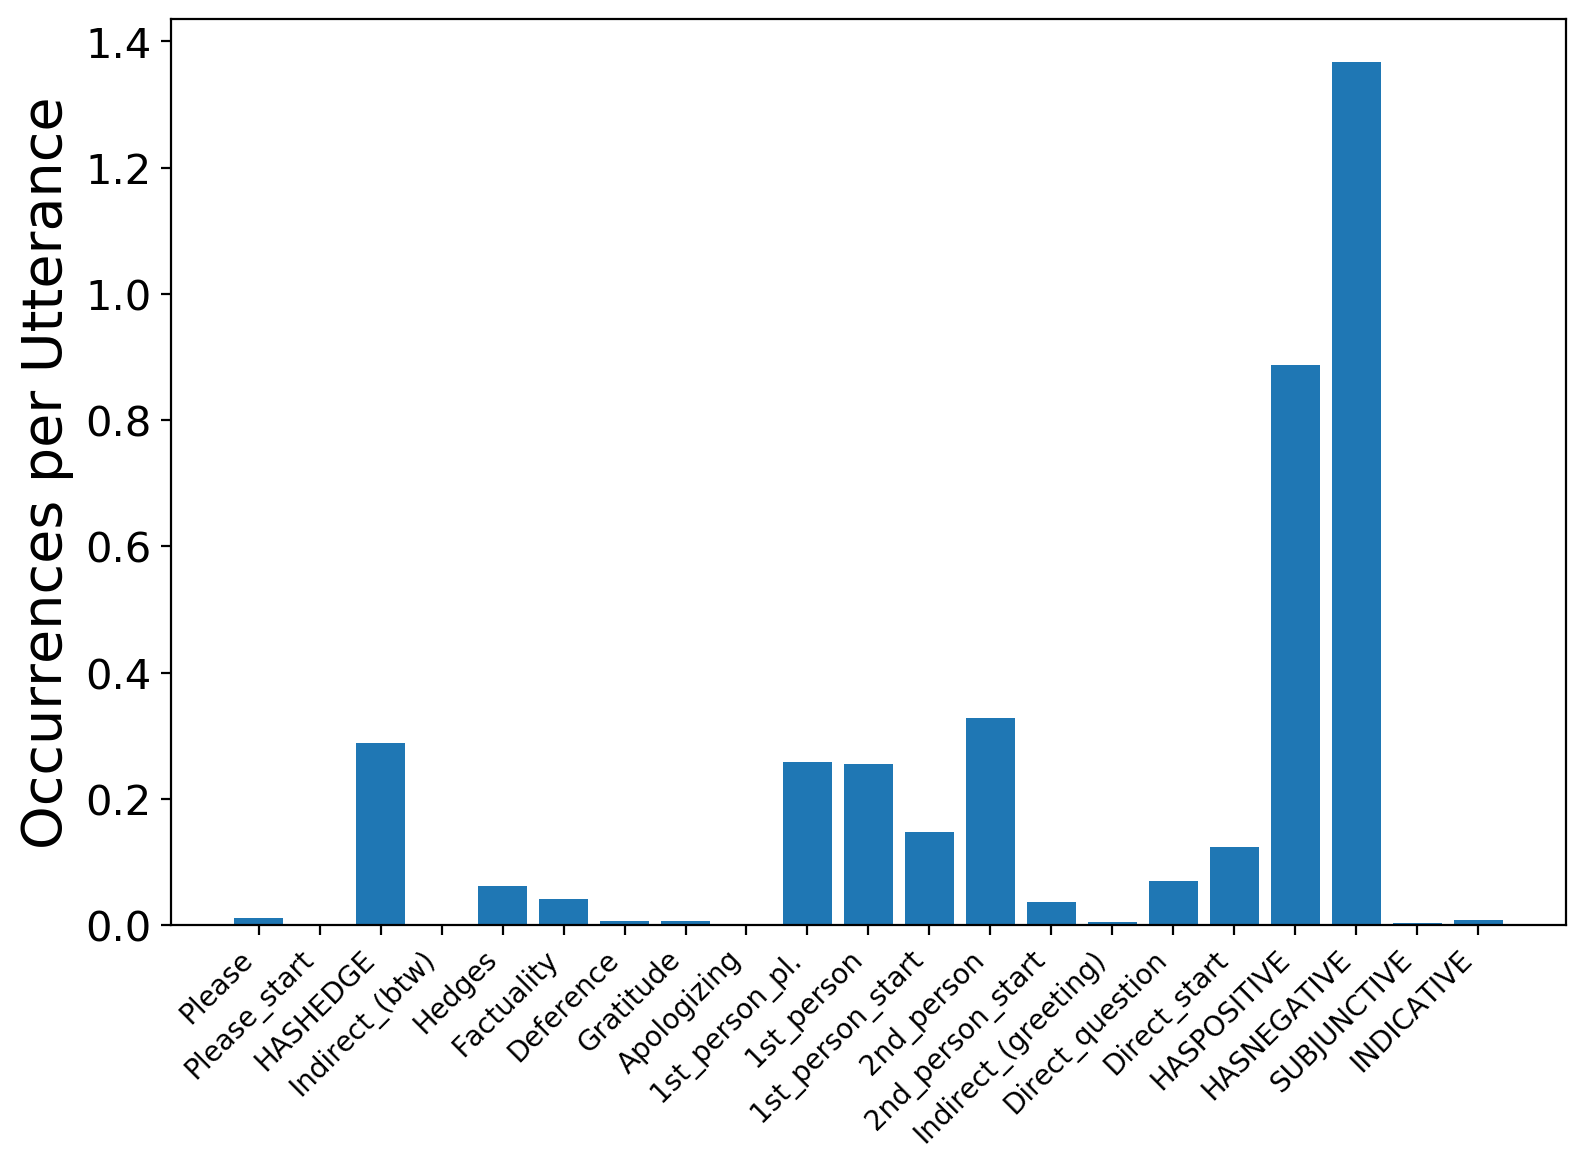

,Averages
Please,0.012
Please_start,0.002
HASHEDGE,0.289
Indirect_(btw),0.000
Hedges,0.062
Factuality,0.042
Deference,0.007
Gratitude,0.006
Apologizing,0.001
1st_person_pl.,0.259


In [44]:
ps.summarize(my_corpus, plot=True)

In [45]:
my_corpus

In [50]:
for i in tqdm(range(len(list(my_corpus.utterances.values())))):
    utt = my_corpus.get_utterance(str(i))

    politeness_score = 0
    for ((k1,v1),(k2,v2)) in zip(utt.meta["politeness_strategies"].items(),utt.meta["politeness_markers"].items()):
        print('****')
        print(k1, v1)
        
        print(k2, v2)
        # break
        # politeness_score += len(v2)
    break
    # res.append(politeness_score)

  0%|          | 0/1000 [00:00<?, ?it/s]

****
feature_politeness_==Please== 0
politeness_markers_==Please== []
****
feature_politeness_==Please_start== 0
politeness_markers_==Please_start== []
****
feature_politeness_==HASHEDGE== 0
politeness_markers_==HASHEDGE== []
****
feature_politeness_==Indirect_(btw)== 0
politeness_markers_==Indirect_(btw)== []
****
feature_politeness_==Hedges== 0
politeness_markers_==Hedges== []
****
feature_politeness_==Factuality== 0
politeness_markers_==Factuality== []
****
feature_politeness_==Deference== 0
politeness_markers_==Deference== []
****
feature_politeness_==Gratitude== 0
politeness_markers_==Gratitude== []
****
feature_politeness_==Apologizing== 0
politeness_markers_==Apologizing== []
****
feature_politeness_==1st_person_pl.== 0
politeness_markers_==1st_person_pl.== []
****
feature_politeness_==1st_person== 0
politeness_markers_==1st_person== []
****
feature_politeness_==1st_person_start== 0
politeness_markers_==1st_person_start== []
****
feature_politeness_==2nd_person== 0
politeness_ma

In [ ]:
# score computation
# res = []
# for i in tqdm(range(len(list(corpus.utterances.values())))):
#     utt = corpus.get_utterance(str(i))

#     politeness_score = 0
#     for ((k,v),(k1,v2)) in zip(utt.meta["politeness_strategies"].items(),utt.meta["politeness_markers"].items()):
#         politeness_score += len(v2)
#     res.append(politeness_score)